## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему. 

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv` 

In [2]:
# pip install gdown

In [4]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

# !pip3 install gdown

# import gdown
# # train
# url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

# output = 'train.csv'
# gdown.download(url, output, quiet=True)

# # test
# url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

# output = 'test.csv'
# gdown.download(url, output, quiet=True)

# # user features
# url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
# output = 'users.csv'
# gdown.download(url, output, quiet=True, fuzzy=True)

# # item features
# url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
# output = 'items.csv'
# gdown.download(url, output, quiet=True)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
# from tqdm import tqdm
import sys
import os

In [36]:
# import pandas as pd
pd.read_csv('../data/users.csv')

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно. 

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [37]:
train_df = pd.read_csv('../data/train.csv')

<Axes: >

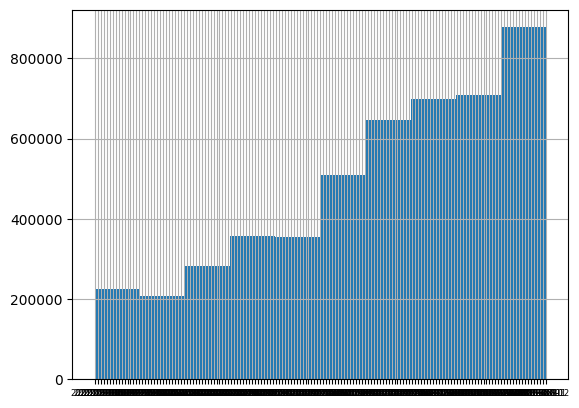

In [38]:
train_df.last_watch_dt.hist(xlabelsize = 6)

In [39]:
train_df.last_watch_dt.value_counts()[:22].sum()/train_df.last_watch_dt.value_counts().sum()

0.25025436843891746

In [7]:
#последние 22 дня составляют около четверти от всех данных – будем использовать их для валидации
# приведём данные о времени к числовым значениям

In [40]:
train_df['last_watch_dt'] = (pd.to_datetime(train_df['last_watch_dt']) - pd.to_datetime(train_df['last_watch_dt']).min())
train_df['last_watch_dt'] = train_df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))

In [41]:
train_stage_1 = train_df[~train_df.last_watch_dt.isin([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152])]
valid_stage_1 = train_df[train_df.last_watch_dt.isin([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152])]

In [64]:
# в качестве алгоритмичной модели будем использовать модифицированный TopPop с семинаров с поправкой на таргеты
# каждому пользователю будем отправлять одинаковый набор наиболее релевантных (глобально) айтемов
# для формирования параметров в моделях далее будет небольшой EDA
# https://github.com/anamarina/RecSys_course/blob/2025/week2/Seminar2.ipynb

In [42]:
train_stage_1.target.sum()/len(train_stage_1)

0.46481120184139857

In [43]:
print(f'''0.99: {train_stage_1.item_id.value_counts().quantile(0.99)}''')
print(f'''0.95: {train_stage_1.item_id.value_counts().quantile(0.95)}''')
print(f'''0.9: {train_stage_1.item_id.value_counts().quantile(0.9)}''')
print(f'''0.75: {train_stage_1.item_id.value_counts().quantile(0.75)}''')
print(f'''0.5: {train_stage_1.item_id.value_counts().quantile(0.5)}''')
print(f'''0.25: {train_stage_1.item_id.value_counts().quantile(0.25)}''')
print(f'''0.1: {train_stage_1.item_id.value_counts().quantile(0.1)}''')

0.99: 3176.639999999996
0.95: 884.5999999999985
0.9: 409.0
0.75: 72.0
0.5: 10.0
0.25: 2.0
0.1: 1.0


In [13]:
# данные сильно сдвинуты 

In [44]:
sys.path.append(os.path.abspath(os.path.join('..', 'models')))
from my_heuristic_model import TopPopularNew  
from my_matrix_factorization import ALS as myALS
from my_neural_network import NNRecommender 

In [45]:
toppop = TopPopularNew()
als_recom = myALS()
nn_recom = NNRecommender()

In [46]:
heuristic_model = toppop
matrix_factorization = als_recom
neural_network = nn_recom

Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)). 

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [43]:
# вот тут я несколько запутался в сути задания, поэтому делаю следующее: 
# все фичи считаются за весь накопленный период (неважно, в трейне, валиде или тесте), 
# так как предполагается, что при переходе в тест о существовавших пользователях информацию мы не потеряли))

# в качестве train_df_with_features использую срез valid_stage_1 по времени, в качестве test_df_with_features использую тест
# скоры моделей первого уровня обучаю на train_stage_1 и делаю predict и для train_df_with_features и для test_df_with_features

In [47]:
users = pd.read_csv('../data/users.csv')
users.head(5)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [48]:
df_test = pd.read_csv('../data/test.csv')

In [49]:
df_test['last_watch_dt'] = (pd.to_datetime(df_test['last_watch_dt']) - pd.to_datetime(train_df['last_watch_dt']).min()) #чтобы соединить всё в один датасет
df_test['last_watch_dt'] = df_test.last_watch_dt.apply(lambda x: int(str(x).split()[0]))

In [50]:
full_df = pd.concat([train_df, df_test])

In [51]:
df_train_full = pd.merge(full_df, users, on = 'user_id', how = 'left')
df_train_full.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg
0,310745,13373,0,4485,98.0,1,age_35_44,income_90_150,М,1.0
1,952323,15997,0,7507,100.0,1,age_35_44,income_40_60,Ж,0.0
2,889459,11460,0,60,0.0,0,age_25_34,income_40_60,Ж,1.0
3,854016,11237,0,5381,98.0,1,age_45_54,income_60_90,М,1.0
4,307257,9132,0,5814,100.0,1,age_55_64,income_20_40,Ж,0.0


In [52]:
# фичи по юзеру 
df_train_full_user = df_train_full.copy()
df_train_full_user = df_train_full_user.sort_values(by=['age', 'income', 'sex', 'kids_flg', 'last_watch_dt'])

df_train_full_user['average_watched_pct'] = (
    df_train_full_user.groupby(['age', 'income', 'sex', 'kids_flg'])['watched_pct']
    .expanding()
    .mean()
    .reset_index(level=[0, 1, 2, 3], drop=True)
)

df_train_full_user['average_total_dur'] = (
    df_train_full_user.groupby(['age', 'income', 'sex', 'kids_flg'])['total_dur']
    .expanding()
    .mean()
    .reset_index(level=[0, 1, 2, 3], drop=True)
)

users_expanded_data = df_train_full_user[['user_id', 'last_watch_dt', 'average_watched_pct', 'average_total_dur']]


In [53]:
# фичи по айтему 
df_train_full_item = df_train_full_user.copy()

df_train_full_item = df_train_full_item.sort_values(by=['item_id', 'last_watch_dt'])

df_train_full_item['average_watched_pct_item'] = (
    df_train_full_item.groupby('item_id')['watched_pct']
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)  
)

df_train_full_item['average_total_dur_item'] = (
    df_train_full_item.groupby('item_id')['total_dur']
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)  
)

items_expanded_data = df_train_full_item[['item_id', 'last_watch_dt', 'average_watched_pct_item', 'average_total_dur_item']]


In [54]:
# фичи по юзеру и айтему 

df_train_full_item_w_user = df_train_full_item.copy()

df_train_full_item_w_user['average_watched_pct_age'] = (
    df_train_full_item_w_user.groupby(['age', 'item_id'])['watched_pct'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

df_train_full_item_w_user['average_total_dur_age'] = (
    df_train_full_item_w_user.groupby(['age', 'item_id'])['total_dur'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

df_train_full_item_w_user['average_watched_pct_income'] = (
    df_train_full_item_w_user.groupby(['income', 'item_id'])['watched_pct'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

df_train_full_item_w_user['average_total_dur_income'] = (
    df_train_full_item_w_user.groupby(['income', 'item_id'])['total_dur'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

df_train_full_item_w_user['average_watched_pct_sex'] = (
    df_train_full_item_w_user.groupby(['sex', 'item_id'])['watched_pct'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

df_train_full_item_w_user['average_total_dur_sex'] = (
    df_train_full_item_w_user.groupby(['sex', 'item_id'])['total_dur'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

df_train_full_item_w_user['average_watched_pct_kids_flg'] = (
    df_train_full_item_w_user.groupby(['kids_flg', 'item_id'])['watched_pct'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

df_train_full_item_w_user['average_total_dur_kids_flg'] = (
    df_train_full_item_w_user.groupby(['kids_flg', 'item_id'])['total_dur'].expanding().mean().reset_index(level=[0, 1], drop=True)
)

users_w_items_expanded_data = df_train_full_item_w_user[['user_id', 'item_id', 'last_watch_dt', 'average_watched_pct_age', 'average_total_dur_age',
                                           'average_watched_pct_income', 'average_total_dur_income', 'average_watched_pct_sex',
                                           'average_total_dur_sex', 'average_watched_pct_kids_flg', 'average_total_dur_kids_flg']]


In [55]:
df_train_full_item_w_user = df_train_full_item_w_user[['user_id', 'item_id', 'last_watch_dt', 'average_watched_pct', 'average_total_dur', 'average_watched_pct_item', 
                           'average_total_dur_item', 'average_watched_pct_age', 'average_total_dur_age',
                            'average_watched_pct_income', 'average_total_dur_income', 'average_watched_pct_sex',
                           'average_total_dur_sex', 'average_watched_pct_kids_flg', 'average_total_dur_kids_flg', 'target']]

In [56]:
train_df_with_features = df_train_full_item_w_user[df_train_full_item_w_user.last_watch_dt.isin([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152])] # берём изначальный набор дат из valid_stage_1

test_df_with_features = df_train_full_item_w_user[df_train_full_item_w_user.last_watch_dt > 152] # всё что позже – тест  


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [ ]:
# добавляем фичи моделей первого уровня
# модели первого уровня будем обучать на данных за train_stage_1 

In [57]:
heuristic_model.fit(train_stage_1)

In [59]:
train_df_with_features['toppop_score'] = heuristic_model.get_score(train_stage_1, valid_stage_1)
test_df_with_features['toppop_score'] = heuristic_model.get_score(train_stage_1, df_test)

/var/folders/fr/sm3p1z5134n_22q36lgf_lc80000gn/T/ipykernel_35284/1843815511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_with_features['toppop_score'] = heuristic_model.get_score(train_stage_1, valid_stage_1)
/var/folders/fr/sm3p1z5134n_22q36lgf_lc80000gn/T/ipykernel_35284/1843815511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_with_features['toppop_score'] = heuristic_model.get_score(train_stage_1, df_test)


In [63]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score

In [67]:
model = CatBoostClassifier(verbose = 0)

In [76]:
# YOUR FIT PREDICT CODE HERE
model.fit(train_df_with_features.drop(['item_id', 'user_id', 'last_watch_dt', 'target'], axis = 1), train_df_with_features.target)
preds = model.predict(test_df_with_features.drop('target', axis = 1))

In [77]:
f1_score(preds, test_df_with_features.target)

0.33045600122007013

In [78]:
roc_auc_score(preds, test_df_with_features.target)

0.6399825690962174

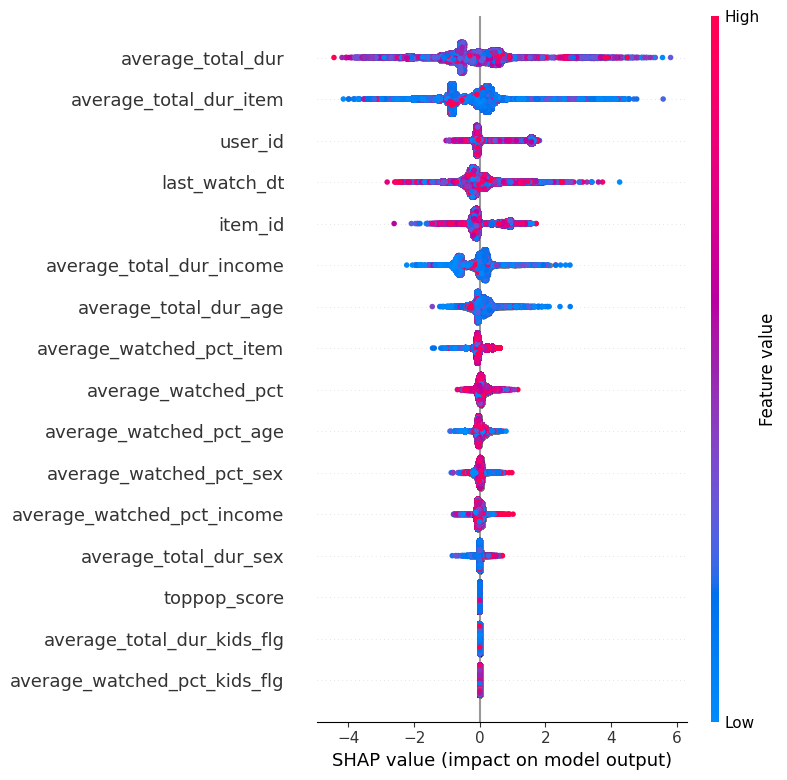

In [79]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_df_with_features.drop('target', axis = 1))

shap.summary_plot(shap_values, test_df_with_features.drop('target', axis = 1))

In [ ]:
# в целом выглядит норм 


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [3]:
# YOUR CODE HERE